## 1.1 Approximating $x!$ and $\binom{N}{k}$

## 1.2 Error-correcting codes fort he binary symmetric channel

In [331]:
import requests as rq
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [66]:
IMAGE_SHAPE = (200, 400)

In [67]:
source = rq.get('https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Martini_Toren.JPG/1200px-Martini_Toren.JPG')

if source.ok:
    image = Image.open(BytesIO(source.content)).resize(IMAGE_SHAPE)

    # For a binary symmetric model we need to have an image that is either 0 (0) or 1 (255)
    bw_image = image.convert('L').point(lambda x: 255 if x > 127 else 0, "1")

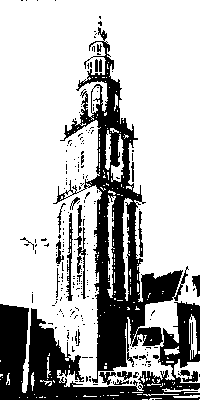

In [68]:
bw_image

In [103]:
s = np.array(bw_image).astype(int).flatten().astype(dtype=np.uint8) # NOTE that you need .T for loading

In [277]:
class BaseClass():
    def encode(self, source):
        pass

    def decode(self):
        pass

    def transport(self, error_prob: float = 0.10):
        if not hasattr(self, "encoded"):
            raise ValueError("First encode a message using self.encode")

        if error_prob >= 0.50:
            raise ValueError("Error prob needs to be <= 50%")

        self.received = (self.encoded + stats.bernoulli(p=error_prob).rvs(self.encoded.size)) % 2

### Repetition codes

The repitition coding is the simplest example where we just take each bit and send it not once but N times. In this case we follow the R3 pattern, meaning that each bit is represented by 3 bits. 

In [317]:
class Repetition(BaseClass):
    def __init__(self, n_repetition: int = 3):
        if n_repetition % 2 == 0:
            raise ValueError("Majority vote only works for odd parity number of repetitions") 

        self.source = None
        self.decoded = None
        self.n_repetition = n_repetition

    def encode(self, source):
        self.source = source
        self.encoded = np.repeat(source, self.n_repetition)

    def decode(self):
        stacked = np.vstack(np.array_split(self.received, self.source.size))
                            
        self.decoded = (stacked.mean(axis=1) > 0.50).astype(np.uint8)

In [332]:
perc_error = []
transmit_size = []


for n_rep in np.arange(1, 40, step=2):
    r3 = Repetition(n_repetition=n_rep)
    r3.encode(s)
    r3.transport(error_prob=0.30)
    r3.decode()

    perc_error.append(np.logical_xor(r3.source, r3.decoded).mean().item())
    transmit_size.append(r3.encoded.size)

stats_df = pd.DataFrame({
    "per_error": perc_error,
    "size": transmit_size
})

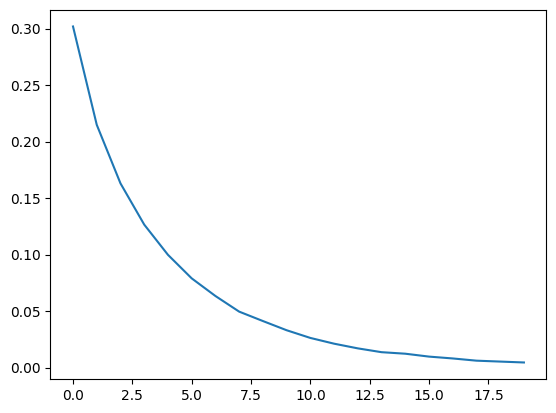

In [325]:
plt.plot(perc_error)
plt.xlabel('num repetitions

### The (7, 3) Hamming code

In [111]:
np.repeat([0,1], 10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])